# Q-Learning: sophisticated types of action selection

**Q-Learning** is arguably one of the most influential ways of combining insights from learning and **trial and error** on the one hand as well as **optimal control theory** on the other. You will see that it is based on a subtle twist of the TD algorithm.

This will only be a brief introduction to Q-Learning, but we will look into this in more detail later.

The structure of the code is inspired by Sutton and Barto, Chapter 6.5 and based on the Q-learning tutorial from Neuromatch 2020 (https://academy.neuromatch.io/nma2020/course-materials). Next week we will explore these concepts in more details, this week its only about getting a conceptual teaser.

We start with the usual imports and defining some helper functions.

In [28]:
# Imports
import numpy as np                 
import matplotlib.pyplot as plt

In [29]:
#@title Helper functions

# taken from Neuromatch tutorial, we will define our own version next week..
from scipy.signal import convolve as conv

def epsilon_greedy(q, epsilon):
  """Epsilon-greedy policy: selects the maximum value action with probabilty
  (1-epsilon) and selects randomly with epsilon probability.
    
  Args:
    q (ndarray): an array of action values
    epsilon (float): probability of selecting an action randomly 
  
  Returns:
    int: the chosen action
  """
  if np.random.random() > epsilon:
    action = np.argmax(q)
  else:
    action = np.random.choice(len(q)) 

  return action


class CliffWorld:
  """
  World: Cliff world.
  40 states (4-by-10 grid world).
  The mapping from state to the grids are as follows:
  30 31 32 ... 39
  20 21 22 ... 29
  10 11 12 ... 19
  0  1  2  ...  9
  0 is the starting state (S) and 9 is the goal state (G).
  Actions 0, 1, 2, 3 correspond to right, up, left, down.
  Moving anywhere from state 9 (goal state) will end the session.
  Taking action down at state 11-18 will go back to state 0 and incur a
      reward of -100.
  Landing in any states other than the goal state will incur a reward of -1.
  Going towards the border when already at the border will stay in the same
      place.
  """
  def __init__(self):
    self.name = "cliff_world"
    self.n_states = 40
    self.n_actions = 4
    self.dim_x = 10
    self.dim_y = 4
    self.init_state = 0

  def get_outcome(self, state, action):
    if state == 9:  # goal state
      reward = 0
      next_state = None
      return next_state, reward
    reward = -1  # default reward value
    if action == 0:  # move right
      next_state = state + 1
      if state % 10 == 9:  # right border
        next_state = state
      elif state == 0:  # start state (next state is cliff)
        next_state = None
        reward = -100
    elif action == 1:  # move up
      next_state = state + 10
      if state >= 30:  # top border
        next_state = state
    elif action == 2:  # move left
      next_state = state - 1
      if state % 10 == 0:  # left border
        next_state = state
    elif action == 3:  # move down
      next_state = state - 10
      if state >= 11 and state <= 18:  # next is cliff
        next_state = None
        reward = -100
      elif state <= 9:  # bottom border
        next_state = state
    else:
      print("Action must be between 0 and 3.")
      next_state = None
      reward = None
    return int(next_state) if next_state is not None else None, reward

  def get_all_outcomes(self):
    outcomes = {}
    for state in range(self.n_states):
      for action in range(self.n_actions):
        next_state, reward = self.get_outcome(state, action)
        outcomes[state, action] = [(1, next_state, reward)]
    return outcomes
  

def learn_environment(env, learning_rule, params, max_steps, n_episodes): 
  # Start with a uniform value function
  value = np.ones((env.n_states, env.n_actions))

  # Run learning
  reward_sums = np.zeros(n_episodes)

  # Loop over episodes
  for episode in range(n_episodes):
    state = env.init_state  # initialize state    
    reward_sum = 0

    for t in range(max_steps):
      # choose next action
      action = epsilon_greedy(value[state], params['epsilon'])
      
      # observe outcome of action on environment
      next_state, reward = env.get_outcome(state, action)

      # update value function
      value = learning_rule(state, action, reward, next_state, value, params["alpha"], params["gamma"])
      
      # sum rewards obtained
      reward_sum += reward
      
      if next_state is None:
          break  # episode ends
      state = next_state      
      
      reward_sums[episode] = reward_sum
  
  return value, reward_sums


def plot_state_action_values(env, value, ax=None):
  """
  Generate plot showing value of each action at each state.
  """
  if ax is None:
    fig, ax = plt.subplots()

  for a in range(env.n_actions): 
    ax.plot(range(env.n_states), value[:, a], marker='o', linestyle='--')
  ax.set(xlabel='States', ylabel='Values')
  ax.legend(['R','U','L','D'], loc='lower right')
  

def plot_quiver_max_action(env, value, ax=None):
  """
  Generate plot showing action of maximum value or maximum probability at
    each state (not for n-armed bandit or cheese_world).
  """
  if ax is None:
    fig, ax = plt.subplots()

  X = np.tile(np.arange(env.dim_x), [env.dim_y,1]) + 0.5
  Y = np.tile(np.arange(env.dim_y)[::-1][:,np.newaxis], [1,env.dim_x]) + 0.5
  which_max = np.reshape(value.argmax(axis=1), (env.dim_y,env.dim_x))
  which_max = which_max[::-1,:]
  U = np.zeros(X.shape)
  V = np.zeros(X.shape)
  U[which_max == 0] = 1
  V[which_max == 1] = 1
  U[which_max == 2] = -1
  V[which_max == 3] = -1
  
  ax.quiver(X, Y, U, V)
  ax.set(
      title='Maximum value/probability actions',
      xlim=[-0.5, env.dim_x+0.5],
      ylim=[-0.5, env.dim_y+0.5],      
  )
  ax.set_xticks(np.linspace(0.5, env.dim_x-0.5, num=env.dim_x))
  ax.set_xticklabels(["%d" % x for x in np.arange(env.dim_x)])
  ax.set_xticks(np.arange(env.dim_x+1), minor=True)
  ax.set_yticks(np.linspace(0.5, env.dim_y-0.5, num=env.dim_y))  
  ax.set_yticklabels(["%d" % y for y in np.arange(0, env.dim_y*env.dim_x, 
                                                  env.dim_x)])  
  ax.set_yticks(np.arange(env.dim_y+1), minor=True)
  ax.grid(which='minor',linestyle='-')


def plot_heatmap_max_val(env, value, ax=None):
  """
  Generate heatmap showing maximum value at each state
  """
  if ax is None:
    fig, ax = plt.subplots()

  if value.ndim == 1:
      value_max = np.reshape(value, (env.dim_y,env.dim_x))
  else:
      value_max = np.reshape(value.max(axis=1), (env.dim_y,env.dim_x))      
  value_max = value_max[::-1,:]

  im = ax.imshow(value_max, aspect='auto', interpolation='none', cmap='afmhot')
  ax.set(title='Maximum value per state')
  ax.set_xticks(np.linspace(0, env.dim_x-1, num=env.dim_x))
  ax.set_xticklabels(["%d" % x for x in np.arange(env.dim_x)])
  ax.set_yticks(np.linspace(0, env.dim_y-1, num=env.dim_y))
  if env.name != 'windy_cliff_grid':
      ax.set_yticklabels(
          ["%d" % y for y in np.arange(
              0, env.dim_y*env.dim_x, env.dim_x)][::-1])
  return im


def plot_rewards(n_episodes, rewards, average_range=10, ax=None):
  """
  Generate plot showing total reward accumulated in each episode.
  """
  if ax is None:
    fig, ax = plt.subplots()

  smoothed_rewards = (conv(rewards, np.ones(average_range), mode='same')
                      / average_range)

  ax.plot(range(0, n_episodes, average_range),
          smoothed_rewards[0:n_episodes:average_range],
          marker='o', linestyle='--')
  ax.set(xlabel='Episodes', ylabel='Total reward')
  

def plot_performance(env, value, reward_sums):
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
  plot_state_action_values(env, value, ax=axes[0,0])
  plot_quiver_max_action(env, value, ax=axes[0,1])
  plot_rewards(n_episodes, reward_sums, ax=axes[1,0])
  im = plot_heatmap_max_val(env, value, ax=axes[1,1])
  fig.colorbar(im)

---
## More complicated environments: Cliff-World

A crucial bit is missing in the multi-armed bandit case: your current actions do not influence what actions you can take in the future, or what states are available some time later.

This is very different from real-world examples. Take navigation for example: if you move into a certain direction, this will prevent you from visiting states in the other direction.

A gold standard paradigm to study this is called cliff-world, which looks like this:

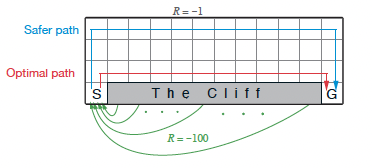

"This is a standard undiscounted, episodic task, with start and goal states, and the usual actions causing movement up, down, right, and left. Reward is −1 on all transitions except those into the region marked “The Cliff.” Stepping into this region incurs a reward of −100 and sends the agent instantly back to the start." (Sutton & Barto, p132)

## Q-Learning

One of the most influential algorithms to solve such tasks is called **Q-learning**, which takes the form:

\begin{align}
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha \big(r_t + \gamma\max_\limits{a} Q(s_{t+1},a_{t+1}) - Q(s_t,a_t)\big)
\end{align}

Note that we are not estimating the value of a state $V(s_t)$ any more, but the value of a specific action $a_t$ in a specific state $s_t$, which we write as $Q(s_t,a_t)$

In [30]:
# @title Exercise 1.1: Understanding the algorithm

Can you guess what the algorithm is doing? How is it comparable to TD-learning, how does it differ? What does the max operation do you think?

In [31]:
# @title Exercise 1.2: Implement Q-Learning

Define a function called q_learning, which implements the above algorithm. Hint: this will look very similar to the update_action_value() in the previous Action Selection Tutorial, except that is has to follow the specifics of the above equation.

In [32]:
# Your code goes here..

In [33]:
# @title Partial Solution
# based on Neuromatch tutorial

def q_learning(state, action, reward, next_state, value, alpha, gamma):
  
  """Q-learning: updates the value function and returns it.
  
  Args:
    state:  current state identifier
    action: action taken
    reward: reward received
    next_state: transitioned to state identifier
    value: current value function of shape (n_states, n_actions)
    alpha: learning rate
    gamma: discount rate
 
  Returns:
    value: the updated value function of shape (n_states, n_actions)
  """

  # Q-value of current state-action pair
  # q = ...

  # find maximum Q-value at the current state
  # if next_state is None:
  #   max_next_q = 0
  # else:
    # max_next_q = ...

  # write the expression to compute the (TD type) error
  # td_error = ...

  # write the expression that updates the Q-value for the state-action pair  
  value = 0
  # value[state, action] = ...
  
  return value

In [34]:
# @title Full Solution
# based on Neuromatch tutorial

def q_learning(state, action, reward, next_state, value, alpha, gamma):
  
  """Q-learning: updates the value function and returns it.
  
  Args:
    state:  current state identifier
    action: action taken
    reward: reward received
    next_state: transitioned to state identifier
    value: current value function of shape (n_states, n_actions)
    alpha: learning rate
    gamma: discount rate
 
  Returns:
    value: the updated value function of shape (n_states, n_actions)
  """

  # Q-value of current state-action pair
  q = value[state, action]

  # find maximum Q-value at the current state
  if next_state is None:
    max_next_q = 0
  else:
    max_next_q = np.max(value[next_state,:])

  # write the expression to compute the (TD type) error
  td_error = reward + gamma * max_next_q - q

  # write the expression that updates the Q-value for the state-action pair  
  value[state, action] = q + alpha * td_error
  
  return value

## Test Performance

We can now see how Q-learning performs in the above cliff-world environment. This is based on helper functions defined above - don't worry too much about them, we will look into the details next week.

This is just to introduce the idea, and check how Q-learning is performing:

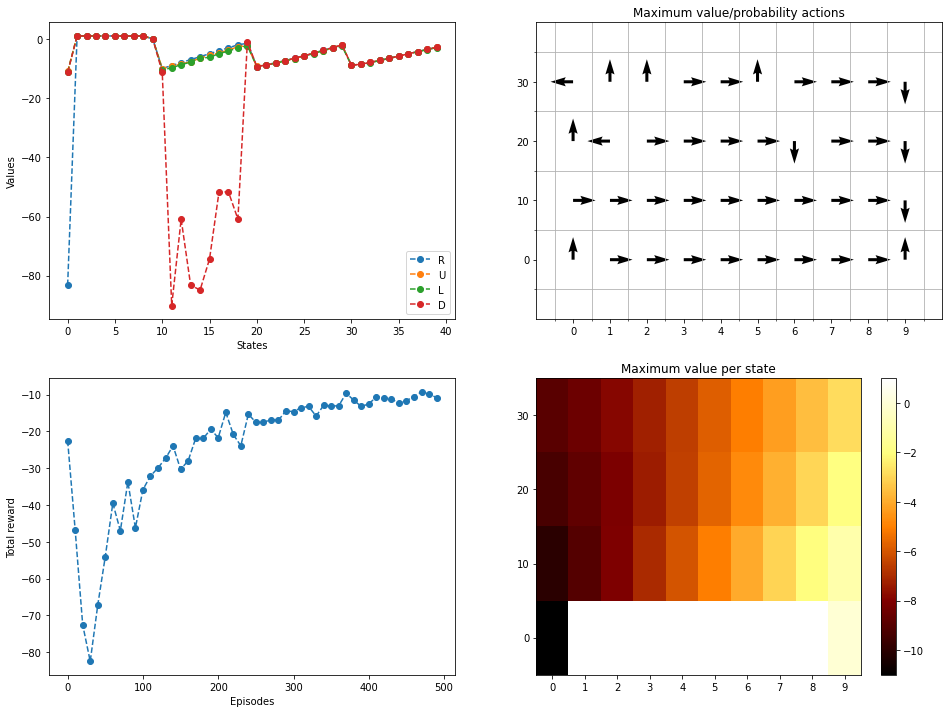

In [35]:
# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

# parameters needed by our policy and learning rule
params = {
  'epsilon': 0.1,  # epsilon-greedy policy
  'alpha': 0.1,  # learning rate    
  'gamma': 1.0,  # discount factor
}

# episodes/trials
n_episodes = 500
max_steps = 1000

# environment initialization
env = CliffWorld()

# solve Cliff World using Q-learning
results = learn_environment(env, q_learning, params, max_steps, n_episodes)
value_qlearning, reward_sums_qlearning = results

# Plot results
plot_performance(env, value_qlearning, reward_sums_qlearning)

In [ ]:
# @title Exercise 1.3: Understanding the algorithm part II

Can you make sense of the plots above?